# Starfish: PHOENIX Model Notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os

import warnings
import astropy.units as u

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha, HDF5Creator
from Starfish.grid_tools.instruments import SPEX, IGRINS_K, IGRINS
from Starfish.emulator.plotting import plot_emulator, plot_eigenspectra
from Starfish.emulator import Emulator
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel

import scipy.stats as st

import emcee
import arviz as az
import corner

from tqdm import tqdm

# from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']= 'bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [3]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# PHOENIX Models path
phoenix_mod_path = "C:\\Users\\Savio\\Documents\\Research\\phoenix_models\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\PHOENIX-ACES-AGSS-COND-2011\\"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

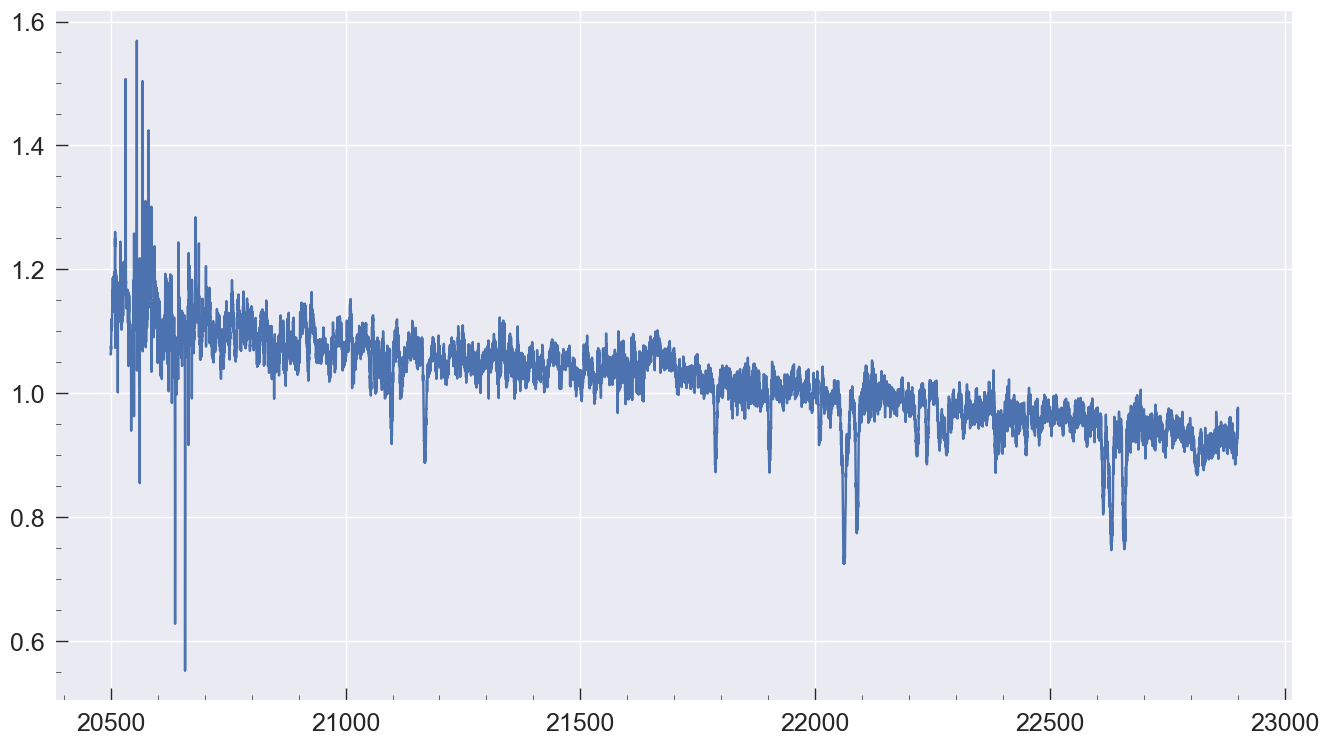

In [195]:
spec = IGRINSSpectrumList.read(standard_table['File'][5])\
    .trim_overlap().stitch().remove_nans().normalize()\

spec = spec.apply_boolean_mask(mask=(~np.isnan(spec.wavelength.value)) &
                                        (spec.wavelength.value > 2.05*1e4) &
                                        (spec.wavelength.value < 2.29*1e4))

plt.plot(spec.wavelength, spec.flux)
# spec.plot()
plt.show()

In [8]:
print("Wavelength Min:", spec.wavelength.value.min())
print("Wavelength Max:", spec.wavelength.value.max())

Wavelength Min: 22000.02142659602
Wavelength Max: 22899.919130511134


# Starfish Setup

In [110]:
from Starfish.grid_tools import download_PHOENIX_models

ranges = [[3000, 5000], [4.0, 6.0], [0, 0.5]]  # T, logg, Z
spex_ranges = [[5700, 8600], [4.0, 6.0], [-0.5, 0.5]] 

download_PHOENIX_models(path=phoenix_mod_path, ranges=ranges)


grid = PHOENIXGridInterfaceNoAlpha(path=phoenix_mod_path)

lte05000-6.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits: 100%|██████████| 210/210 [00:00<00:00, 1057.23it/s]


In [93]:
spex_creator = HDF5Creator(
    grid,
    "starfish_hdf5\\F_SPEX_grid.hdf5",
    instrument=SPEX(),
    wl_range=(0.9e4, np.inf),
    ranges=spex_ranges
)
spex_creator.process_grid()

Processing [7.e+03 6.e+00 5.e-01]: 100%|██████████| 210/210 [04:46<00:00,  1.36s/it]      


In [95]:
# can load from string or HDF5Interface
spex_emu = Emulator.from_grid("starfish_hdf5\\F_SPEX_grid.hdf5")
spex_emu

Emulator
--------
Trained: False
lambda_xi: 1.000
Variances:
	10000.00
	10000.00
	10000.00
	10000.00
Lengthscales:
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
Log Likelihood: -1187.81

In [96]:
%time spex_emu.train(options=dict(maxiter=1e5, disp=True))
spex_emu

Optimization terminated successfully.
         Current function value: 761.951711
         Iterations: 4081
         Function evaluations: 5384
CPU times: total: 9min 30s
Wall time: 1min 12s


Emulator
--------
Trained: True
lambda_xi: 0.998
Variances:
	76491.48
	1632.95
	800.28
	394.29
Lengthscales:
	[ 1148.22  4.55  1.30 ]
	[ 1390.10  1.28  1.40 ]
	[ 1563.43  2.11  1.40 ]
	[ 645.06  1.02  1.00 ]
Log Likelihood: -761.95

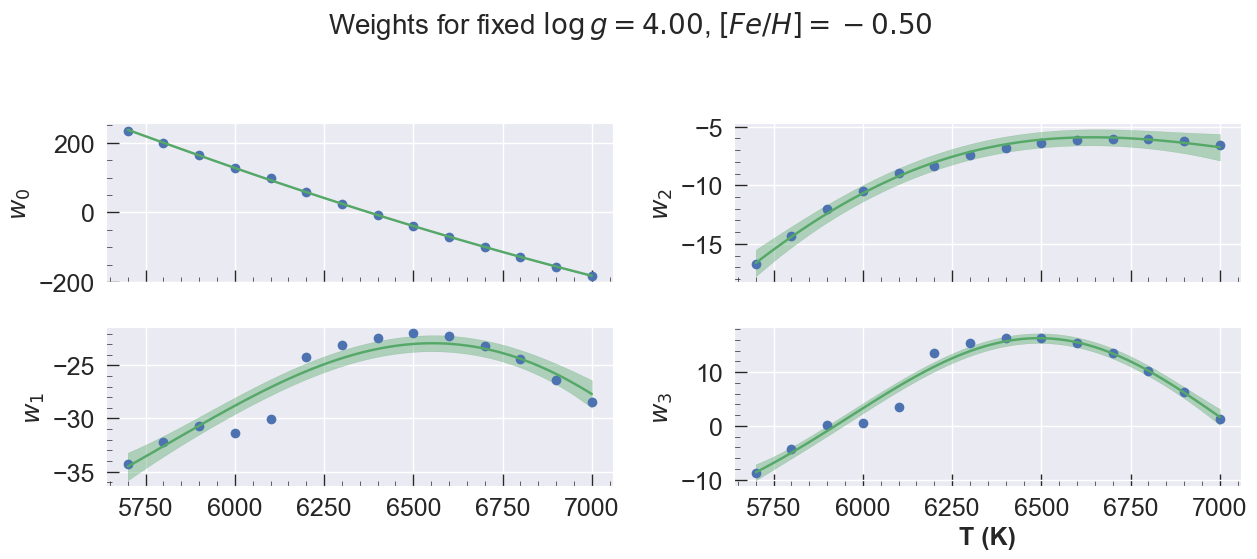

In [98]:
plot_emulator(spex_emu)

In [100]:
spex_emu.save("starfish_hdf5\\F_SPEX_emu.hdf5")

In [111]:
creator = HDF5Creator(
    grid,
    "starfish_hdf5\\F_IGRINS_grid.hdf5",
    instrument=IGRINS_K(),
    ranges=ranges
)
creator.process_grid()

Processing [5.e+03 6.e+00 5.e-01]: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]   


In [112]:
# can load from string or HDF5Interface
emu = Emulator.from_grid("starfish_hdf5\\F_IGRINS_grid.hdf5")
emu

Emulator
--------
Trained: False
lambda_xi: 1.000
Variances:
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
	10000.00
Lengthscales:
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
	[ 300.00  1.50  1.50 ]
Log Likelihood: -2686.28

In [107]:
# # spec.plot(color='k',zorder=20)
# plt.plot(spec.wavelength,
#             spec.flux,
#             color='k',
#             label='Data',
#             zorder=2
#             )

# plt.fill_between(x=spec.wavelength.value,
#             y1=spec.flux.value - spec.uncertainty.array,
#             y2=spec.flux.value + spec.uncertainty.array,
#             color='k',
#             alpha=0.5,
#             zorder=1)

# plt.plot(emu.wl,
#             emu.flux_mean,
#             label='Model Grid Mean Flux',
#             zorder=4
#             )

# plt.fill_between(x=emu.wl,
#             y1=emu.flux_mean - emu.flux_std,
#             y2=emu.flux_mean + emu.flux_std,
#             color='r',
#             alpha=0.5,
#             zorder=3)

# # plt.xlim(2.255e4,2.27e4)
# plt.legend()
# plt.show()

In [113]:
%time emu.train(options=dict(maxiter=1e5, disp=True))
emu

Optimization terminated successfully.
         Current function value: 2363.470493
         Iterations: 22209
         Function evaluations: 26502
CPU times: total: 3h 13min 50s
Wall time: 24min 32s


Emulator
--------
Trained: True
lambda_xi: 1.006
Variances:
	43223.55
	19227.29
	3789.39
	82850.66
	5862.15
	5219.30
	2201.04
	8398.65
Lengthscales:
	[ 432.72  1.57  1.40 ]
	[ 349.67  1.05  1.21 ]
	[ 326.69  1.01  1.00 ]
	[ 521.82  1.24  3.39 ]
	[ 354.81  1.22  1.19 ]
	[ 491.37  2.06  1.14 ]
	[ 326.15  1.57  1.28 ]
	[ 425.56  1.27  1.63 ]
Log Likelihood: -2363.47

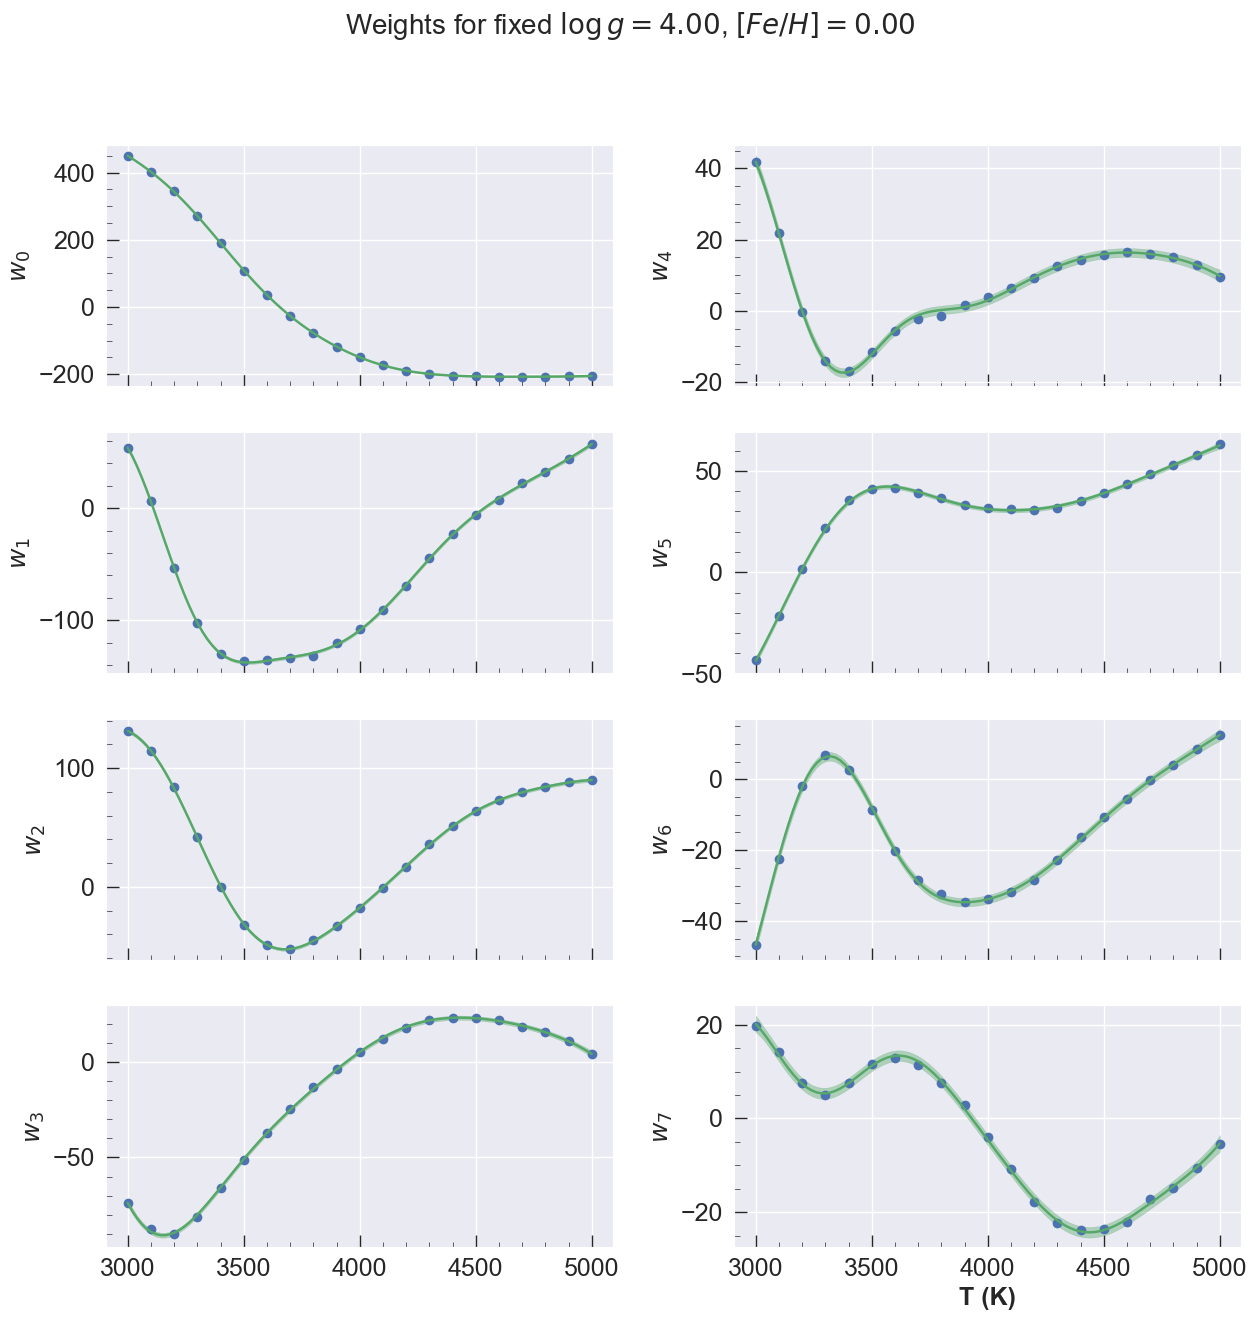

In [114]:
plot_emulator(emu)

In [115]:
emu.save("starfish_hdf5\\F_IGRINS_K_emu.hdf5")

# Single Order Spectrum

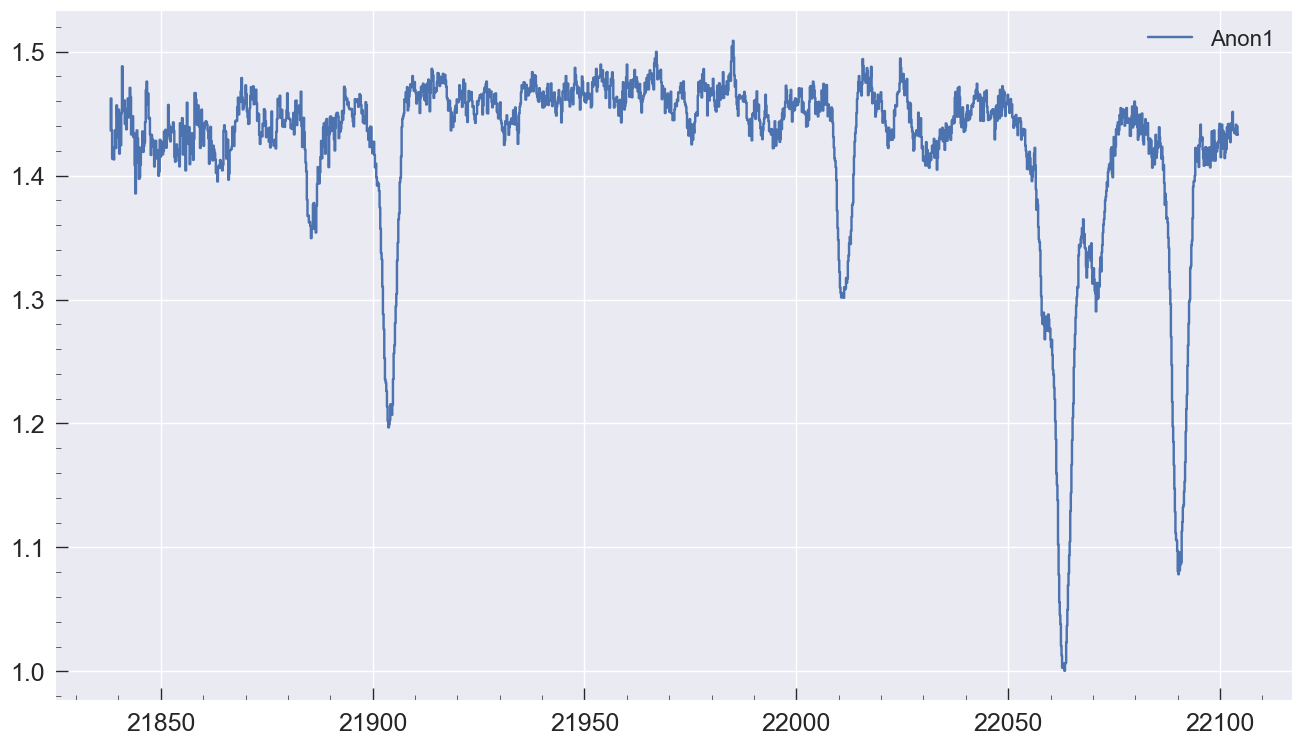

In [136]:
spec_n = 3
spec = IGRINSSpectrumList.read(standard_table['File'][spec_n]).trim_overlap().remove_nans().normalize()

# spec = spec.apply_boolean_mask(mask=(~np.isnan(spec.wavelength.value)) &
#                                         (spec.wavelength.value > 21000) &
#                                         (spec.wavelength.value < 23000)).remove_nans().normalize()

order=14
plt.step(spec[order].wavelength,spec[order].flux, label=f"{standard_table['Name'][spec_n]}")
plt.legend()
plt.show()

In [137]:
spec.to_HDF5("starfish_hdf5\\",f"{standard_table['Name'][spec_n]}")

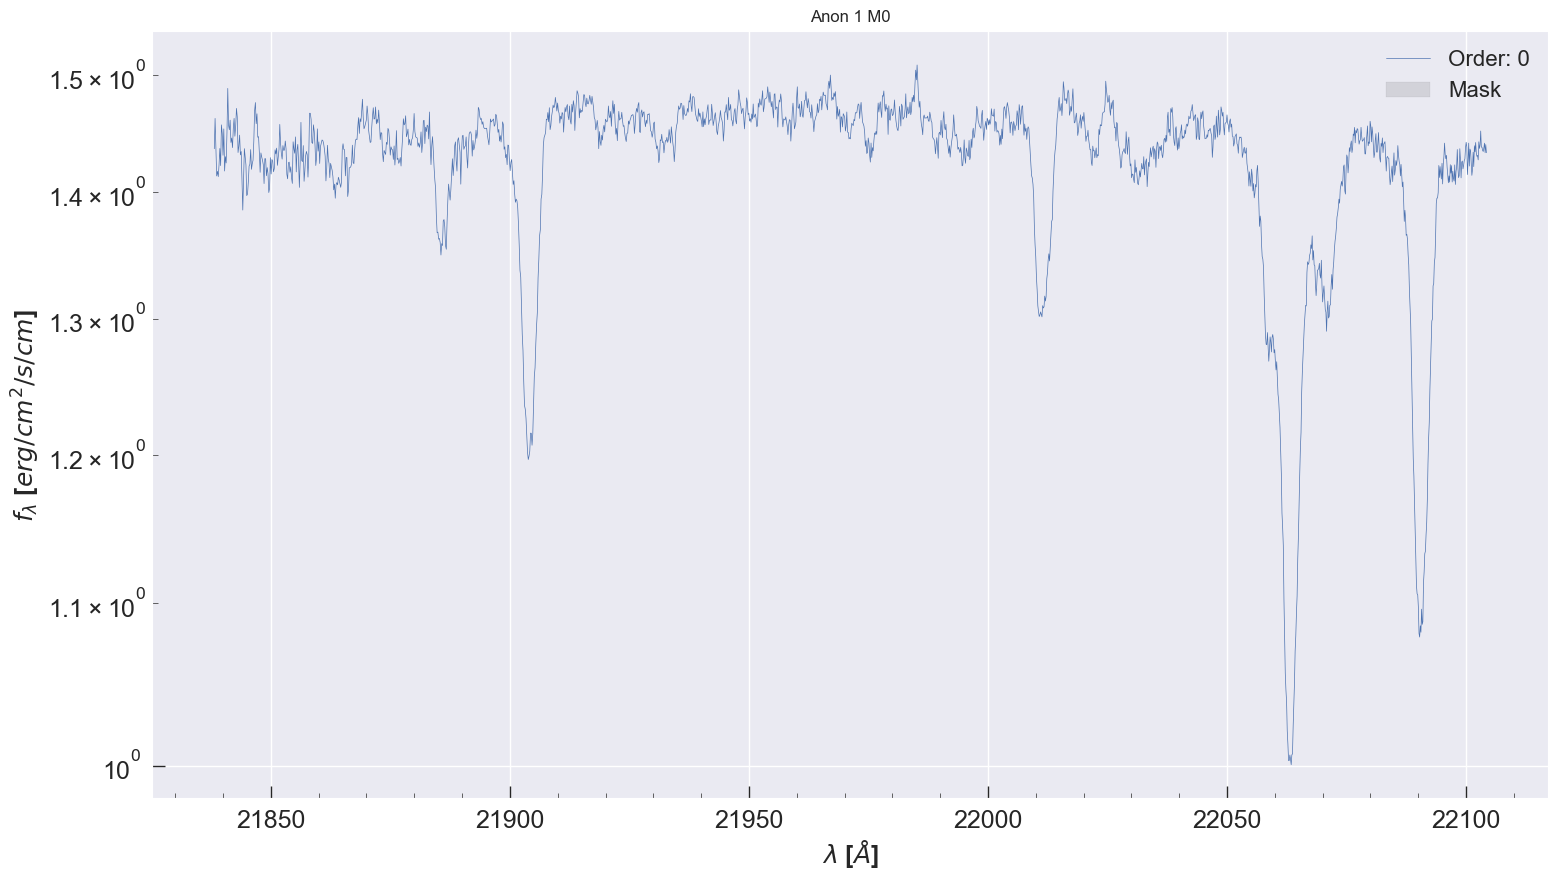

In [139]:
data = Spectrum.load("starfish_hdf5\Anon1_m081.hdf5")

data.plot()
plt.title("Anon 1 M0")
plt.show()

In [179]:
model = SpectrumModel(
    "starfish_hdf5\\F_IGRINS_K_emu.hdf5",
    data,
    grid_params=[4500, 4.5, 0],
    Av=0,
    global_cov=dict(log_amp=38, log_ls=2),
)
model

SpectrumModel
-------------
Data: None
Emulator: starfish_hdf5\F_IGRINS_K_emu
Log Likelihood: None

Parameters
  Av: 0
  global_cov:
    log_amp: 38
    log_ls: 2
  T: 4500
  logg: 4.5
  Z: 0
  log_scale: 0.453643238759443 (fit)

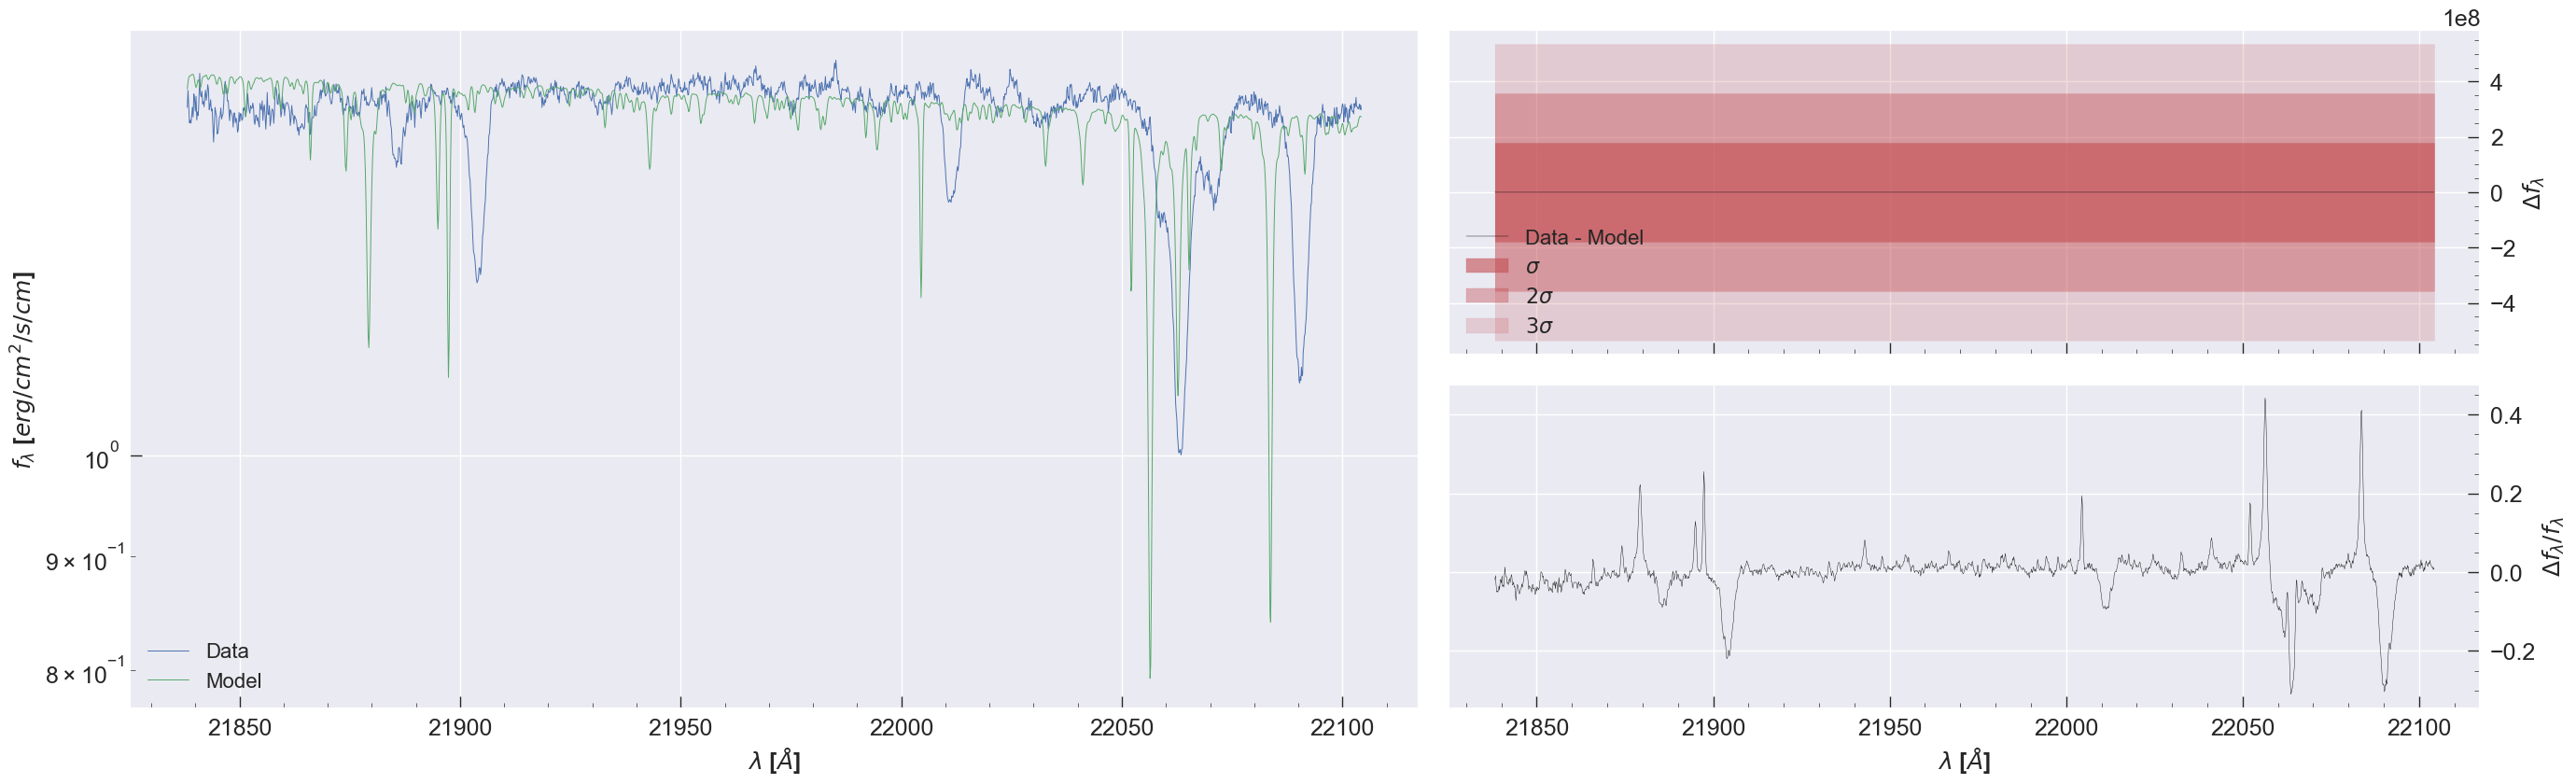

In [180]:
model.plot()
plt.show()

# Numerical Optimization

In [173]:
model.freeze("logg")
model.labels  # These are the fittable parameters

('Av', 'global_cov:log_amp', 'global_cov:log_ls', 'T', 'Z')

In [174]:
import scipy.stats as st

priors = {
    "T": st.norm(3900, 100),
    "Z": st.uniform(-0.5, 0.5),
    "Av": st.halfnorm(0, 0.2),
    "global_cov:log_amp": st.norm(38, 1),
    "global_cov:log_ls": st.uniform(0, 10),
}

In [175]:
# emu.grid_points

In [176]:
%time model.train(priors)

ValueError: Querying emulator outside of original parameter range.

In [ ]:
model

In [ ]:
model.plot()

# MCMC Sampling